# Install packages

##!pip install geopandas
##! pip install earthengine-api --upgrade
##!pip install rasterio
##!pip install gdal
#!pip install osgeo
##!conda install -c conda-forge gdal
##!pip install pysheds
!pip install cartopy
!pip install deap

In [1]:
import numpy
import rasterio
import cartopy
import sys
import pylab as pl
from osgeo import gdal, osr
import numpy as np
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.features import rasterize
from rasterio.transform import from_origin
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.features import rasterize
from rasterio.transform import from_origin
from rasterio.mask import mask
import matplotlib.pyplot as plt
import tempfile
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.features import rasterize
from rasterio.transform import from_origin
from rasterio.mask import mask
import matplotlib.pyplot as plt
import tempfile
from rasterio.enums import Resampling
import richdem as rd
import whitebox
import os

##import gdal
##!pip show gdal

In [2]:
#!pip install geopandas rasterio numpy
#!pip install richdem
#!pip install whitebox


In [3]:
from wmf import wmf 
import pylab as pl 
from osgeo import gdal
from wmf import ghost_topo as go 
import numpy as np


# Set up a watershed 

## Read and process DEM 

def convert_map_to_tif(input_map, output_tif):
    # Open the PCRaster .map file
    ds = gdal.Open(input_map)
    if ds is None:
        raise Exception("Could not open input file")

    # Create the GeoTIFF driver
    driver = gdal.GetDriverByName('GTiff')

    # Create the GeoTIFF output file
    ds_tif = driver.CreateCopy(output_tif, ds)

    # Close the datasets
    ds = None
    ds_tif = None

    print("Conversion complete.")

if __name__ == "__main__":
    input_map_file = "Dir30.map"
    output_tif_file = "OT30.tif"
    convert_map_to_tif(input_map_file, output_tif_file)


from wmf import wmf
from osgeo import gdal
DEM, epsg = wmf.read_map_raster('dem2.tif', isDEMorDIR=True, dxp=90, noDataP=-9999)
DIR, epsg = wmf.read_map_raster('dir.tif', isDEMorDIR=True, dxp=90, noDataP=-9999, isDIR=False)

### Raster resampling and scaling

In [8]:
def multiply_raster_values(input_path, output_path, factor):
    # Open the original raster
    with rasterio.open(input_path) as src:
        # Read the raster data and mask
        data = src.read(1, masked=True)  # Read band 1 with masking


        # Multiply the raster values by the factor
        data = data * factor
        
        # Update metadata
        meta = src.meta.copy()
        
        # Write the modified raster to a new file
        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(data.filled(meta['nodata']), 1)  # Write to band 1, using the original NoData value

def resample_raster(input_path, output_path, new_cell_size):
    # Open the modified raster
    with rasterio.open(input_path) as src:
        # Calculate new dimensions based on new cell size
        old_cell_size_x, old_cell_size_y = src.res
        scale_factor_x = old_cell_size_x / new_cell_size
        scale_factor_y = old_cell_size_y / new_cell_size
        
        new_width = int(src.width * scale_factor_x)
        new_height = int(src.height * scale_factor_y)

        # Define new transformation
        transform = src.transform * src.transform.scale(
            (src.width / new_width),
            (src.height / new_height)
        )

        # Set the new metadata
        new_meta = src.meta.copy()
        new_meta.update({
            'driver': 'GTiff',
            'height': new_height,
            'width': new_width,
            'transform': transform
        })

        # Write the resampled raster
        with rasterio.open(output_path, 'w', **new_meta) as dst:
            dst.write(
                src.read(
                    1,
                    out_shape=(new_height, new_width),
                    resampling=Resampling.bilinear
                ),
                1  # Writing to band 1
            )

# File paths
input_raster_path = "/mnt/c/Users/Miguel/desktop/WMF/Middle_Cedar_CT15/NewDem.tif"
temp_raster_path = "/mnt/c/Users/Miguel/desktop/WMF/Middle_Cedar_CT15/temp_dem.tif"
final_raster_path = "/mnt/c/Users/Miguel/desktop/WMF/Middle_Cedar_CT15/dem.tif"

# Parameters
factor = 0.01
new_cell_size = 20  # Desired new cell size in units of the raster's coordinate system

# Perform operations
multiply_raster_values(input_raster_path, temp_raster_path, factor)
resample_raster(temp_raster_path, final_raster_path, new_cell_size)

def calculate_flow_direction(dem_path, flow_dir_path):
    wbt = whitebox.WhiteboxTools()
    
    # Ensure that the whitebox tools executable is in the system path
    wbt.set_whitebox_dir(os.path.dirname(whitebox.__file__))
    
    # Calculate flow directions using D8 algorithm
    wbt.d8_pointer(dem=dem_path, output=flow_dir_path)

# File paths
final_raster_path = "/mnt/c/Users/Miguel/desktop/wmf/Boone_CT 16/dem.tif"
flow_dir_path = "/mnt/c/Users/Miguel/desktop/wmf/Boone_CT 16/dir.tif"

# Calculate flow direction
calculate_flow_direction(final_raster_path, flow_dir_path)

In [28]:
from wmf import wmf
from osgeo import gdal
DEM, epsg = wmf.read_map_raster('dem.tif', isDEMorDIR=True, dxp=30, noDataP=-9999)
DIR, epsg = wmf.read_map_raster('dir.tif', isDEMorDIR=True, dxp=30, noDataP=-9999, isDIR=False)
# Define the value modification dictionary
value_mapping = {32: 7, 64: 8, 128: 9, 16: 4, 1: 6, 8: 1, 4: 2, 2: 3}

# Apply the value modifications using NumPy
modified_DIR = np.copy(DIR)
for orig_value, new_value in value_mapping.items():
    modified_DIR[DIR == orig_value] = new_value

# Set null values to 0
modified_DIR[modified_DIR == -9999] = 0

# Open the original dataset to get geotransformation and spatial reference
original_dataset = gdal.Open('dir.tif')
geotransform = original_dataset.GetGeoTransform()
spatial_ref = original_dataset.GetProjection()

# Write the modified data (including null values) back to the raster file
output_file = 'dir1.tif'
driver = gdal.GetDriverByName('GTiff')
output_dataset = driver.Create(output_file, DIR.shape[0], DIR.shape[1], 1, gdal.GDT_Byte)  # Transposed shape
output_band = output_dataset.GetRasterBand(1)
output_band.WriteArray(modified_DIR.T)  # Transpose the modified data array
output_band.SetNoDataValue(0)  # Set null value to 0

# Set the same spatial reference as the original dataset
output_dataset.SetProjection(spatial_ref)

# Set the same geotransformation as the original dataset
output_dataset.SetGeoTransform(geotransform)

output_band.FlushCache()
output_band = None
output_dataset = None
original_dataset = None

print("Value modifications completed. Modified file saved as 'dir1.tif'.")

Value modifications completed. Modified file saved as 'dir1.tif'.


DIR, epsg = wmf.read_map_raster('dir30c.tif', isDEMorDIR=True, dxp=90, noDataP=-9999, isDIR=False)

In [4]:
from wmf import wmf
from osgeo import gdal
DEM, epsg = wmf.read_map_raster('dem.tif', isDEMorDIR=True, dxp=20, noDataP=-9999)
DIR, epsg = wmf.read_map_raster('dir1.tif', isDEMorDIR=True, dxp=20, noDataP=-9999, isDIR=False)

## Extract watershed

In [15]:
st = wmf.Stream(575826.037888, 4650931.96359, DEM, DIR) # Top point stream
cu = wmf.SimuBasin(571569.440022, 4641136.0366, DEM, DIR, stream=st, threshold=50) # Catchment
Cat3, prop, epsg = wmf.read_map_raster('dir1.tif')
Cat2, prop, epsg = wmf.read_map_raster('dem.tif')
# Cat, prop, epsg = wmf.read_map_raster('dem.tif')


1


In [16]:
Cat3Basin = cu.Transform_Map2Basin(Cat3, prop)
Cat2Basin = cu.Transform_Map2Basin(Cat2, prop)

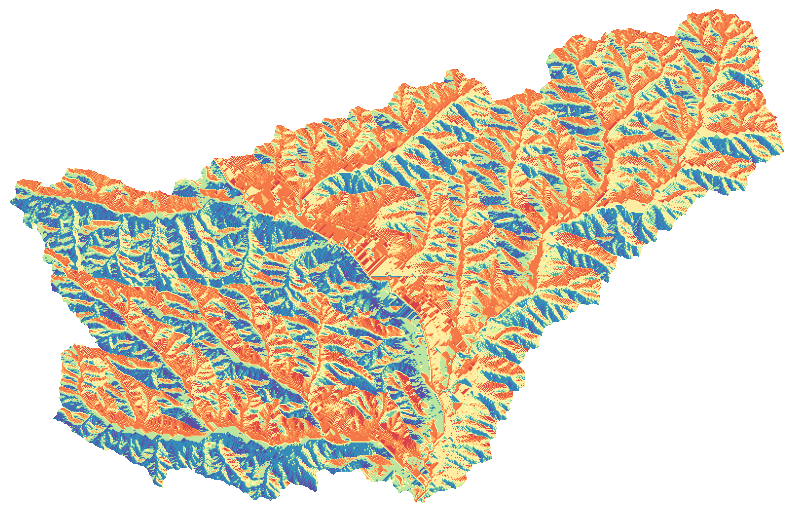

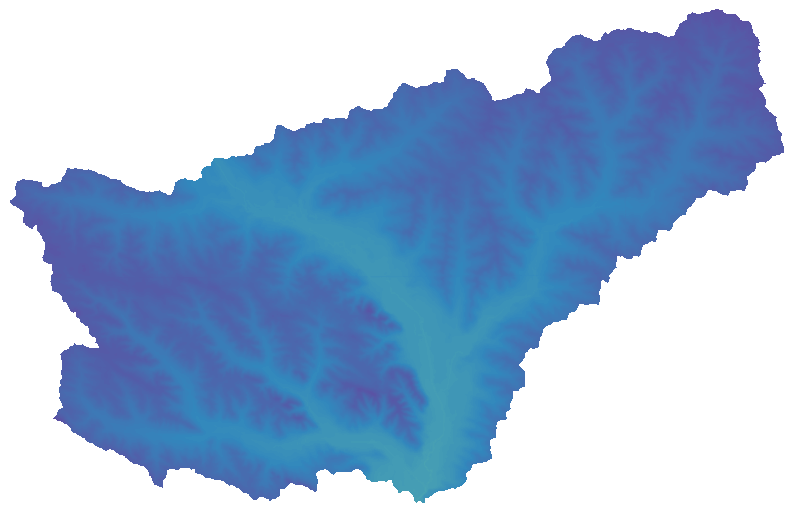

(([563129.5625, 579049.5625, 4641454.5, 4651594.5], <Axes: >),
 ([563129.5625, 579049.5625, 4641454.5, 4651594.5], <Axes: >))

In [17]:
cu.Plot_basinClean(Cat3Basin), cu.Plot_basinClean(Cat2Basin)

In [54]:
cu.Save_Basin2Map('Basin.shp',
    dx=20,
    Param={},
    DriverFormat='ESRI Shapefile',
    EPSG=26915,
    GeoParam=False,
)
cu.Save_Net2Map('Net.shp',
    dx=20,
    threshold=200,
    qmed=None,
    Dict=None,
    DriverFormat='ESRI Shapefile',
    EPSG=26915,
    Numlink_id=True,
    formato='%.2f',
)

### Create Focus_Dict Raster

In [18]:

# Define the input shapefiles
soapcreek_shapefile = "/mnt/c/Users/Miguel/desktop/wmf/Middle_Cedar_CT15/Basin.shp"
net_buff_shapefile = "/mnt/c/Users/Miguel/desktop/wmf/Middle_Cedar_CT15/Net_Buffer.shp"
make_ingrid_shapefile = "/mnt/c/Users/Miguel/desktop/wmf/Middle_Cedar_CT15/Pool.shp"

# Define the output raster
output_raster = "/mnt/c/Users/Miguel/desktop/wmf/Middle_Cedar_CT15/focus_dic.tif"

# Read the shapefiles using geopandas
soapcreek_gdf = gpd.read_file(soapcreek_shapefile)
net_buff_gdf = gpd.read_file(net_buff_shapefile)
make_ingrid_gdf = gpd.read_file(make_ingrid_shapefile)

# Ensure the GeoDataFrames are in the correct projected CRS (NAD_1983_UTM_Zone_15N)
soapcreek_gdf = soapcreek_gdf.to_crs(epsg=26915)
net_buff_gdf = net_buff_gdf.to_crs(epsg=26915)
make_ingrid_gdf = make_ingrid_gdf.to_crs(epsg=26915)

# Define raster properties
cell_size = 20
xmin, ymin, xmax, ymax = soapcreek_gdf.total_bounds
width = int((xmax - xmin) / cell_size)
height = int((ymax - ymin) / cell_size)
transform = from_origin(xmin, ymax, cell_size, cell_size)

# Function to rasterize a GeoDataFrame
def rasterize_gdf(gdf, transform, out_shape, zone_value):
    shapes = ((geom, zone_value) for geom in gdf.geometry)
    return rasterize(shapes, transform=transform, out_shape=out_shape, fill=0, dtype=rasterio.uint8)

# Create empty raster initialized with NoData (value 0)
combined_raster = np.zeros((height, width), dtype=np.uint8)

# Rasterize Make_Ingrid layer and assign zone value 3
combined_raster = rasterize_gdf(make_ingrid_gdf, transform, (height, width), 3)

# Rasterize SoapCreek layer and assign zone value 1, ensuring it doesn't overwrite existing values
soapcreek_raster = rasterize_gdf(soapcreek_gdf, transform, (height, width), 1)
combined_raster[combined_raster == 0] = soapcreek_raster[combined_raster == 0]

# Rasterize NET_Buff layer and assign zone value 2, ensuring it overwrites existing values where applicable
net_buff_raster = rasterize_gdf(net_buff_gdf, transform, (height, width), 2)
combined_raster[net_buff_raster != 0] = 2

# Debug: Plot the combined raster before masking
plt.imshow(combined_raster, cmap='gray')
plt.title('Combined Raster Before Masking')
plt.show()

# Create a temporary file to store the combined raster
with tempfile.NamedTemporaryFile(suffix='.tif') as temp_raster:
    # Write the combined raster to the temporary file
    with rasterio.open(
        temp_raster.name, 'w', driver='GTiff', height=height, width=width, count=1, dtype=rasterio.uint8, transform=transform, crs=soapcreek_gdf.crs.to_string()
    ) as mem_raster:
        mem_raster.write(combined_raster, 1)
    
    # Reopen the temporary file in read mode to apply the mask
    with rasterio.open(temp_raster.name) as src:
        soapcreek_geometry = [geom for geom in soapcreek_gdf.geometry]
        out_image, out_transform = mask(src, soapcreek_geometry, invert=False)
        out_image = out_image[0]  # Extract the array from the masked result

# Set all 0 values to NoData
out_image[out_image == 0] = 255  # Use 255 as the NoData value for an 8-bit raster

# # Debug: Plot the masked raster
# plt.imshow(out_image, cmap='Blues')
# plt.title('Masked Raster')
# plt.show()

# Write the masked raster to a file
with rasterio.open(
    output_raster, 'w', driver='GTiff', height=out_image.shape[0], width=out_image.shape[1], count=1,
    dtype=rasterio.uint8, crs=soapcreek_gdf.crs.to_string(), transform=out_transform, nodata=255
) as dst:
    dst.write(out_image, 1)

print(f"Raster with zones created at {output_raster}")


DriverError: /mnt/c/Users/Miguel/desktop/wmf/Middle_Cedar_CT15/Net_Buffer.shp: No such file or directory

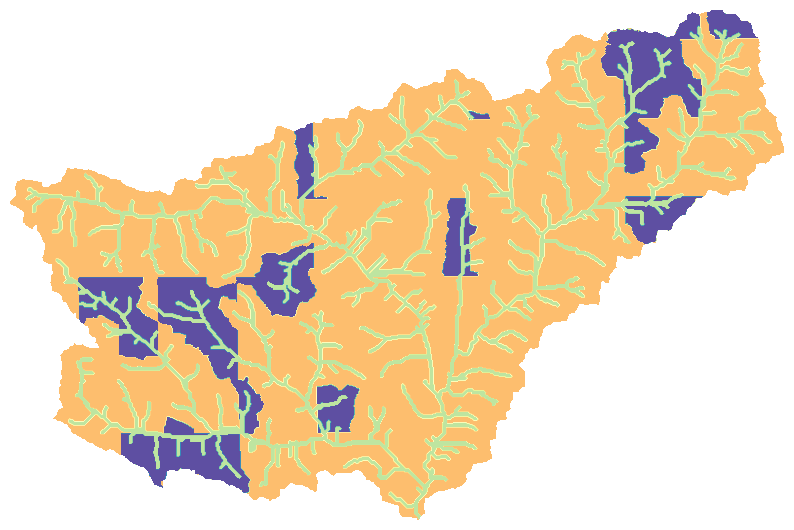

([563129.5625, 579049.5625, 4641114.5, 4651594.5], <Axes: >)

In [39]:
Cat, prop, epsg = wmf.read_map_raster('focus_dic.tif')
CatBasin = cu.Transform_Map2Basin(Cat, prop)
cu.Plot_basinClean(CatBasin)

## Get ghost class and its elements

In [67]:
gp = go.ghost_preprocess(cu, path_dem='dem.tif', 
   seg_threshold=45,
  seg_point_distance=4,)

In [68]:
corrected = gp.get_segments_topology(epsilon=0.1)

In [57]:
gp.get_mesh_river_points(clean_close_points=True,
                         min_river2river_distance=2)

In [69]:
gp.get_mesh_grid_points(mesh_spaces=8,
                        border_iter=5,
                        clean_with_river=True,
                        min_dem2river_distance=5)

import pandas as pd

pd.DataFrame(gp.mesh_points_river.T, columns = ['x','y']).to_csv('mesh_coordinates_river.csv')
pd.DataFrame(gp.mesh_points_dem.T, columns = ['x','y']).to_csv('mesh_coordinates_grid.csv')
pd.DataFrame(gp.mesh_points_boundary[0].T, columns = ['x','y'])kkz.to_csv('mesh_coordinates_boundary.csv')
pd.DataFrame(gp.mesh_points_boundary[1].T, columns = ['x','y']).to_csv('mesh_coordinates_boundary2.csv')

In [72]:
gp.get_voronoi_polygons()
gp.define_polygons_topology()

In [73]:
gp.write_mesh_file('mesh_4.mesh', shp_path='mesh_4.shp')

In [74]:
gp.write_river_file('river_4.riv',shp_path='river_4.shp')

#T

gp.write_attribute_file()

In [10]:
# focus_dic = {'1':{'seg_threshold':45,
#                  'seg_point_distance':35,
#                  'mesh_spaces': 7,
#                  'min_order' : 1}, 
#               '2':{'seg_threshold':18,
#                    'seg_point_distance':2,
#                    'mesh_spaces': 5,
#                    'min_dem2river_distance' : 8,
#                    'min_order' : 1},
#                '3':{'seg_threshold':20,
#                    'seg_point_distance':5,
#                    'mesh_spaces': 6,
#                    'min_dem2river_distance' : 15,
#                    'min_order' : 1}
# }


focus_dic = {'1':{'seg_threshold':100,
                 'seg_point_distance':7,
                 'mesh_spaces': 8,
                 'min_order' : 1}, 
              '2':{'seg_threshold':80,
                   'seg_point_distance':3,
                   'mesh_spaces': 3,
                   'min_dem2river_distance' : 7,
                   'min_order' : 1},
               '3':{'seg_threshold':90,
                   'seg_point_distance':5,
                   'mesh_spaces': 4,
                   'min_dem2river_distance' : 6,
                   'min_order' : 1}
}


gp = go.ghost_preprocess(cu, path_dem='dem.tif', 
    #seg_threshold=800,
  #seg_point_distance=75,
  focus_map = 'focus_dic.TIF',
  focus_dict = focus_dic
  )

corrected = gp.get_segments_topology(epsilon=0.1)
gp.select_segments_using_focus(1)
gp.get_mesh_river_points(clean_close_points=True,
                         min_river2river_distance=50)
gp.get_mesh_grid_points(mesh_spaces=12,
                        border_iter=2,
                        clean_with_river=True,
                        min_dem2river_distance=50)

gp.get_voronoi_polygons()
gp.define_polygons_topology()

Defining river segments...


/home/mike94/def2/lib/python3.8/site-packages/wmf/ghost_topo.py:1063: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  category = int(stats.mode(self.focus_map[pos]).mode[0])


Done
Extracting points for the mesh by focus areas...
Done
Creating border elements...
Done
Cleaning mesh points with the points of the river network...
Using focus setup, will use distance based on the config if avaiable
Done


Renumbering polygons ids ...


Done renumbering


In [11]:
gp.write_mesh_file('meshFocus.mesh','meshFocus3.shp')
gp.write_river_file(path = 'examplFocus.riv', 
                    shp_path = 'example_rivFocus.shp')

Writing mesh file...


Mesh file written
writing shapefile...
Done
Converting shp to ee FeatureCollection...


# Use earth explorer functions to set up the soil properties

#Gets the soil data
soils = go.get_soils_data()
gp.get_physical_prop(soils, sliced=True, xdivisions=5, ydivisions=5, prop_name='soils')
#Fill the geometries with null values.
gp.polygons_shp['soils'].fillna(gp.polygons_shp['soils'].value_counts().idxmax(), 
                                inplace = True)
#Make the variable an integer
gp.polygons_shp['soils'] = gp.polygons_shp['soils'].astype(int)

#Gets the land use data
land_use = go.get_land_use_data()
gp.get_physical_prop(land_use, sliced=True, xdivisions=5, ydivisions=5, prop_name='land', band = 'cropland')
#Make the vartiable and integer
gp.polygons_shp['land'] = gp.polygons_shp['land'].astype(int)


gp.write_attribute_file('/content/drive/MyDrive/GHOST/Outputs/example.att', 
                        'soils', 
                        'land')

# Attribute file 

In [12]:
# Load the shapefile
shapefile_path = 'meshFocus3.shp'
gdf = gpd.read_file(shapefile_path)

# Save the attribute table to a CSV file
output_csv_path = 'meshFocus.csv'
gdf.drop(columns='geometry').to_csv(output_csv_path, index=False)

In [13]:
import pandas as pd

# Load the newly created shapefile CSV and the BearCreek CSV
shapefile_csv = pd.read_csv(output_csv_path)
csv_path = 'BearCreek-att.csv'
csv_df = pd.read_csv(csv_path)

# Ensure the 'polygon' and 'nfaces' columns exist in the shapefile CSV
if 'polygon' not in shapefile_csv.columns or 'nfaces' not in shapefile_csv.columns:
    raise ValueError("The 'polygon' and/or 'nfaces' columns are missing in the shapefile CSV.")

# Extend the BearCreek-att CSV to have the same number of rows as the shapefile CSV if needed
if len(csv_df) < len(shapefile_csv):
    rows_to_add = len(shapefile_csv) - len(csv_df)
    extra_rows = pd.DataFrame(index=range(rows_to_add), columns=csv_df.columns)
    csv_df = pd.concat([csv_df, extra_rows], ignore_index=True)

# Copy the 'polygon' and 'nfaces' values to the 'INDEX' and 'nfaces' columns in the BearCreek CSV
csv_df['INDEX'] = shapefile_csv['polygon']
csv_df['nfaces'] = shapefile_csv['nfaces']

# Fields to extend with the same values till the end of the 'INDEX' column
fields_to_extend = ['SOIL', 'LC', 'METEO', 'LAI', 'SS', 'LAKE', 'CLOSE_SEG']
for field in fields_to_extend:
    if field in csv_df.columns:
        last_value = csv_df[field].iloc[0]
        csv_df[field].fillna(last_value, inplace=True)
    else:
        csv_df[field] = csv_df[field].iloc[0]

# Save the updated BearCreek-att CSV
output_csv_path_updated = 'Middle-att.csv'
csv_df.to_csv(output_csv_path_updated, index=False)

In [14]:
import csv

# Read data from CSV file
df = pd.read_csv('Middle-att.csv')

# Iterate through rows and add zeros to BCns
for index, row in df.iterrows():
    nfaces = int(row['nfaces'])  # Cast to integer
    zeros_to_add = nfaces - 1  # Subtract 1 to account for the existing zero in the BCns column
    zeros = [0] * zeros_to_add
    new_bcns = [0] + zeros  # Add the initial zerat o and then the additional zeros
    df.at[index, 'BCns'] = ','.join(map(str, new_bcns))

# Replace commas with tabs and remove quotes in the BCns column
df['BCns'] = df['BCns'].apply(lambda x: str(x).replace(',', '\t').replace('"', ''))

# Replace commas with tabs for all fields
df_with_tabs = df.applymap(lambda x: str(x).replace(',', '\t'))

# Write the modified data back to a CSV file
df_with_tabs.to_csv('Middle_CT15.att', index=False, sep='\t', quoting=csv.QUOTE_NONE, escapechar=' ')

# 100 - 100 m
import pandas as pd

# Read data from CSV file
# df = pd.read_csv('BearCreek-att.csv')
df = pd.read_csv('BearCreek-att.csv')
# Iterate through rows and add zeros to BCns
for index, row in df.iterrows():
    nfaces = int(row['nfaces'])  # Cast to integer
    zeros_to_add = nfaces - 1  # Subtract 1 to account for the existing zero in the BCns column
    zeros = [0] * zeros_to_add
    new_bcns = [0] + zeros  # Add the initial zero and then the additional zeros
    df.at[index, 'BCns'] = ','.join(map(str, new_bcns))

# Write the modified data back to a CSV file
df.to_csv('BearCreek-Mesh_1.csv', index=False)


# Append attribute file to account for forcing/tiling

## Read in meteo pixels as gdf

!pip install geopandas

In [ ]:
import pandas as pd
import geopandas as geop  # Import geopandas as gpd

# read in pixels.csv from meteo gen file
df = pd.read_csv('pixels.csv')

# convert df to geodataframe point class
pixel_gdf = geop.GeoDataFrame(
    df, geometry=geop.points_from_xy(df.lon, df.lat), crs=4326)

# convert gdf crs to match project (lat to utm)
pixel_gdf = pixel_gdf.to_crs(26915)

## Read in mesh as gdf

In [ ]:
# read in numele from mesh.mesh
with open('mesh.mesh') as f:
  first_line = f.readline()
  f.close()

# obtain value for numele from string
npoly = [int(i) for i in first_line.split() if i.isdigit()]

# create df that excludes geometry data appendage
df = pd.read_csv('mesh.mesh', names=['Index','X','Y','Zmin','Zmax','Area','nFaces'], delimiter="\t", header=1, nrows=npoly[0] )

# create mesh_gdf
mesh_gdf = geop.GeoDataFrame(
    df, geometry=geop.points_from_xy(df.X, df.Y), crs=26915)

## Read in river file as gdf

In [ ]:
# read in numele from exampl.riv
with open('exampl.riv') as f:
  first_line = f.readline()
  f.close()

# obtain value for numele from string
nriv = [int(i) for i in first_line.split() if i.isdigit()]

# create df that excludes geometry data appendage
names = ['Index',	'X',	'Y',	'ZMIN',	'ZMAX',	'LENGTH',	'DOWN',	'LEFT',	'RIGHT',	'SHAPE',	'MATRL',	'BC',	'RES',	'XAREA',	'INACT',	'LAKE',	'LRIV']
df = pd.read_csv('exampl.riv', names=names, delimiter="\t", header=1, nrows=nriv[0] )

# create riv_gdf
riv_gdf = geop.GeoDataFrame(
    df, geometry=geop.points_from_xy(df.X, df.Y), crs=26915)

## Read in attribute file as df

In [ ]:
# define nico's function for reading in attribute file
def read_attfile(path):
  f = open(path,'r')
  lines = f.readlines()
  f.close()
  z = [i.split()[:8] for i in lines[1:]]
  df = pd.DataFrame(z, columns=lines[0].split(' ')[:8])
  df = df.astype(int)
  return df

att_df = read_attfile('example.att')

## Correct meteo assignment for each polygon in attribute file

In [ ]:
def get_nearest_values(row, other_gdf, point_column='geometry', value_column="geometry"):
    """Find the nearest point and return the corresponding value from specified value column."""

    # Create an union of the other GeoDataFrame's geometries:
    other_points = other_gdf["geometry"].unary_union

    # Find the nearest points
    nearest_geoms = shply.ops.nearest_points(row[point_column], other_points)

    # Get corresponding values from the other df
    nearest_data = other_gdf.loc[other_gdf["geometry"] == nearest_geoms[1]]
    nearest_value = nearest_data[value_column].to_numpy()[0]

    return nearest_value

# append mesh_gdf to include meteo value for each polygon
mesh_gdf["nearest_idx"] = mesh_gdf.apply(get_nearest_values, other_gdf=pixel_gdf, value_column="ID", axis=1)

# check min/max pixel id used
max_idx = max(mesh_gdf["nearest_idx"])
display(max_idx)
min_idx = min(mesh_gdf["nearest_idx"])
display(min_idx)

#replace the meteo value in attr with pixel value from mesh
att_df["METEO"] = mesh_gdf["nearest_idx"]

## Correct close_seg assignment for each polygon in attribute file

In [ ]:
# append mesh_gdf to include close_seg value for each polygon
mesh_gdf["close_seg"] = mesh_gdf.apply(get_nearest_values, other_gdf=riv_gdf, value_column="Index", axis=1)

# check min/max close_seg used
max_seg = max(mesh_gdf["close_seg"])
display(max_seg)
min_seg = min(mesh_gdf["close_seg"])
display(min_seg)

#replace the meteo value in attr with pixel value from mesh
att_df["CLOSE_SEG"] = mesh_gdf["close_seg"]

In [ ]:
#replace the meteo value in attr with pixel value from mesh
att_df["CLOSE_SEG"] = mesh_gdf["close_seg"]

## Write updated attribute file

In [ ]:
npoly=npoly[0]

In [ ]:
def write_att(mesh, old_att, path, npoly):
    f = open(path, 'w')
    f.write('INDEX SOIL LC METEO LAI SS LAKE CLOSE_SEG BCns\n')
    for i in range(npoly):
        poly = mesh.loc[i,'Index']
        nfaces = mesh.loc[i,'nFaces']
        #soil = old_att.loc[i,'SOIL']
        #land = old_att.loc[i,'LC']
        meteo = old_att.loc[i,'METEO']
        close_seg = old_att.loc[i,'CLOSE_SEG']
        #f.write('%d %d %d %d 1 0 0 %d ' % (poly, soil, land, meteo, close_seg))
        f.write('%d 1 12 %d 1 0 0 %d ' % (poly, meteo, close_seg))
        for z in range(nfaces):
            f.write('0 ')
        f.write('\n')
    f.close()

write_att(mesh=mesh_gdf, old_att=att_df, path='/content/drive/MyDrive/GHOST/Outputs/revised.att', npoly=npoly)

In [ ]:
cu.Plot_basinClean(cu.structure[0])